<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch 
# !pip3 install torchvision
# !pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

In [0]:
# in_dim = 784 # The size of the flattened image
# out_dim = 10 # These are the things we want to sort it into

class LinearNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearNetwork, self).__init__()
        
        self.net = nn.Sequential( # This is the type of network
            nn.Linear(in_dim, 1000), # This is a layer of the network, we use a linear layer in this case
            nn.ReLU(), # Activation function
            nn.Linear(1000, out_dim))
    
    def forward(self, x):
        '''Runs the input through the neural net'''
        n, c, h, w = x.size()
        flattened = x.view(n, c * h * w)
        return self.net(flattened)


class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(
            root, 
            train=train, 
            transform=transforms.ToTensor(),
            download=True)
    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y

    def __len__(self):
        return 1#len(self.data)

In [0]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
validate_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
c, h, w = train_dataset[0][0].size()
in_dim = c * h * w
n_classes = 10
batch_size = 1
n_epochs = 500
valid_freq = 1


train_loader = DataLoader(train_dataset, # Takes a dataset and formats it easily to pass into a nn
                         batch_size=batch_size,
                         pin_memory=True)
validate_loader = DataLoader(validate_dataset,
                         batch_size=batch_size,
                         pin_memory=True)


model = LinearNetwork(in_dim, n_classes)
model = model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [22]:
loop = tqdm(total=(len(train_loader) * n_epochs), position=0)

def validate(validate_loader):
    validate_loss = []
    for x, y_truth in validate_loader:

        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        validate_loss.append(loss.item())
    
    return np.mean(validate_loss)


valid_loss = []
train_losses = []
for epoch in range(n_epochs):

    batch = 0
    if epoch % valid_freq == 0:
        valid_loss.append(validate(validate_loader))

    for x, y_truth in train_loader:
        x, y_truth = x.cuda(), y_truth.cuda()

        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth)

        train_losses.append(loss)

        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()

loss:0.3144: 100%|██████████| 500/500 [00:03<00:00, 147.97it/s]


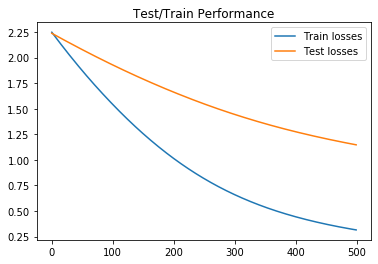

In [23]:
plt.plot(train_losses, label='Train losses')
plt.plot(valid_loss, label='Test losses')
plt.title("Test/Train Performance")

plt.legend()
plt.show()